In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

%matplotlib inline
sns.set_theme(style='whitegrid', palette='deep')

<span style="color:green;font-weight:bold;font-size:20px"> 
Import sets 
</span>

In [4]:
train = pd.read_csv('house-pricing-data/train.csv')
test = pd.read_csv('house-pricing-data/test.csv')
submission = pd.read_csv('house-pricing-data/sample_submission.csv')

train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

<span style="color:green;font-weight:bold;font-size:20px"> 
Defining useful functions
</span>

In [109]:
# create a few functions for quick use
def see_na(df: pd.DataFrame) -> None:
    """
    Function that shows all the NaN values count for each columns in a DataFrame.
    """
    
    nulls = df.isna().sum()
    nulls = nulls[nulls>0]
    print(len(nulls), "null columns\n", nulls)

def pattern_check(df: pd.DataFrame, rgx: str) -> pd.DataFrame:
    """
    Function works by using pattern regex 'rgx' parameter to look for columns 
    that fit that pattern
    """
    
    return df.filter(regex=rgx)

def rename_cols(df: pd.DataFrame, cols: list, cols_newname: list) -> pd.DataFrame:
    """
    Function that renames columns in a DataFrame, both column parameters
    need to have the same length, and the order of the names must be the same.
    """
    
    for i, j in zip(cols, cols_newname):
        df.rename(columns={i: j}, inplace=True)
    return df
    

def _plt(plt_type: str, df_slice: pd.DataFrame, 
         x_val: str=None, y_val: str=None, hue_val: str = None, 
         est: str='mean', X:int=30, Y:int=15) -> None:
    """ Create a plot depending on the plt_type variable 
        plt_type: {'heat', 'scatter', 'line', 'box', 'bar', 'hist', 'reg'}
            'heat' will create a heatmap, 'scatter' will create a scatterplot, 
            'line' a lineplot, 'box' a boxplot, 'bar' a barplot, 
            'hist' a histogram, 'reg' a regplot

        df_slice: the DataFrame to which the plot will be based

        x_val: feature column for the x value
        y_val: target column for the y value

        hue_val: hue value from the DataFrame
    """
    plt_type = plt_type.lower()
    
    plt.figure(figsize=(X,Y))

    if hue_val == None and y_val != None:
        plot_title = f'{x_val}_{y_val}'
    elif hue_val != None and y_val == None:
        plot_title = f'{x_val}_{hue_val}'
    elif hue_val == None and y_val==None:
        plot_title = f'{x_val} plot'
    else:
        plot_title = f'{x_val}_{y_val}_{hue_val}'
    
    match plt_type:
        case 'heat':
            plot_title = 'heatmap'
            sns.heatmap(
                data=df_slice, 
                annot=True, 
                cmap='Purples', 
                center=0, 
                fmt='.2f', 
                linewidths=0.5)
        case 'scatter':
            sns.scatterplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val)
        case 'line':
            sns.lineplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val, 
                marker='o')
        case 'box':
            sns.boxplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                hue=hue_val)
        case 'bar':
            sns.barplot(
                data=df_slice,
                x=x_val, 
                y=y_val, 
                hue=hue_val, 
                palette='Paired',
                errorbar=None,
                estimator=est)
        case 'hist':
            sns.histplot(
                data=df_slice, 
                x=x_val, 
                hue=hue_val, 
                kde=True)
        case 'reg':
            sns.regplot(
                data=df_slice, 
                x=x_val, 
                y=y_val, 
                scatter_kws={'alpha': 0.5},
                line_kws=dict(color="r"),
                ci=99, 
                marker="x", 
                color=".3", 
                order=2)
        case _:
            raise ValueError(f"Unknown plot type: {plt_type}. "
                           f"Available: scatter, line, box, bar, hist, reg")
    
    plt.title(plot_title)
    plt.xticks(rotation=30)
    
    if (hue_val!=None and plt_type not in ['reg']) and hue_val!=x_val:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    
    plt.savefig(f'imgs/{plot_title}.svg', format='svg')
    plt.show()

    

<span style='color:green;font-weight:bold;font-size:20px'>
Exploratory Data Analysis (EDA)
</span>

Check null values in numericals and categoricals

In [75]:
num_df = (
    train_copy
        .select_dtypes(include=np.number)
        .drop(['Id'], axis=1))
num_df_without_target = num_df.drop(['SalePrice'], axis=1)
num_df.isnull().sum().sort_values(ascending=False).head()

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
MSSubClass       0
LotArea          0
dtype: int64

In [39]:
cat_df = (
    train_copy
        .select_dtypes(include='object'))
cat_df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageFinish      81
GarageQual        81
GarageType        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
Electrical         1
Condition1         0
Condition2         0
LotShape           0
Street             0
dtype: int64

Check Skewness

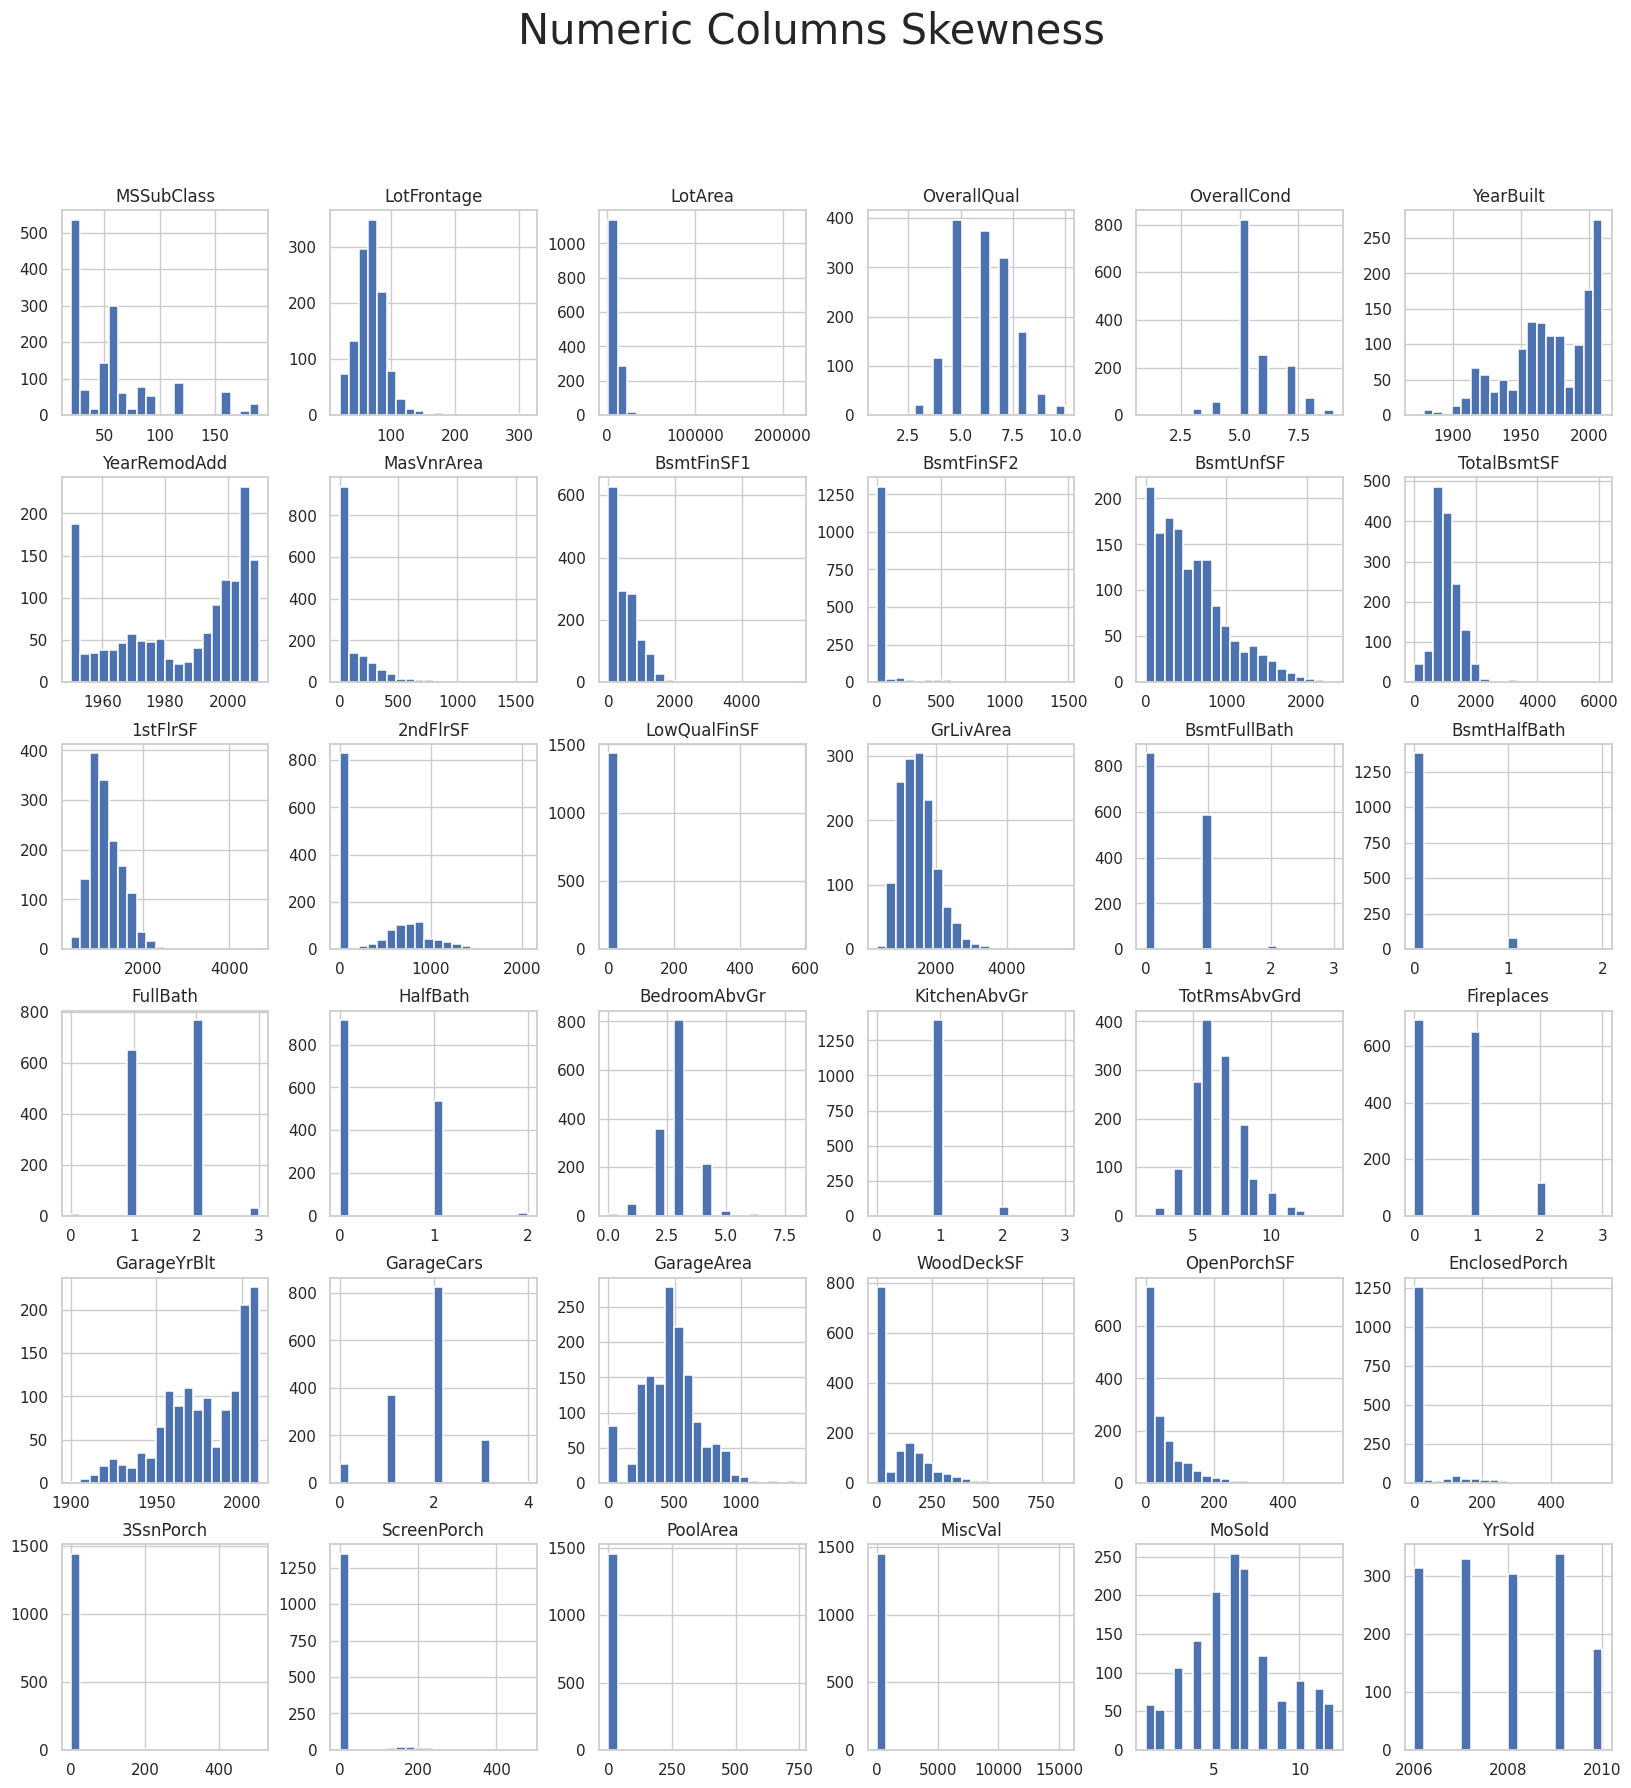

In [77]:
num_df_without_target.hist(bins=20, figsize=(20,20), linewidth=1.1)
plt.suptitle('Numeric Columns Skewness', fontsize=30)
plt.show()

In [78]:
train[num_df_without_target.columns].skew()

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
dtype: float64

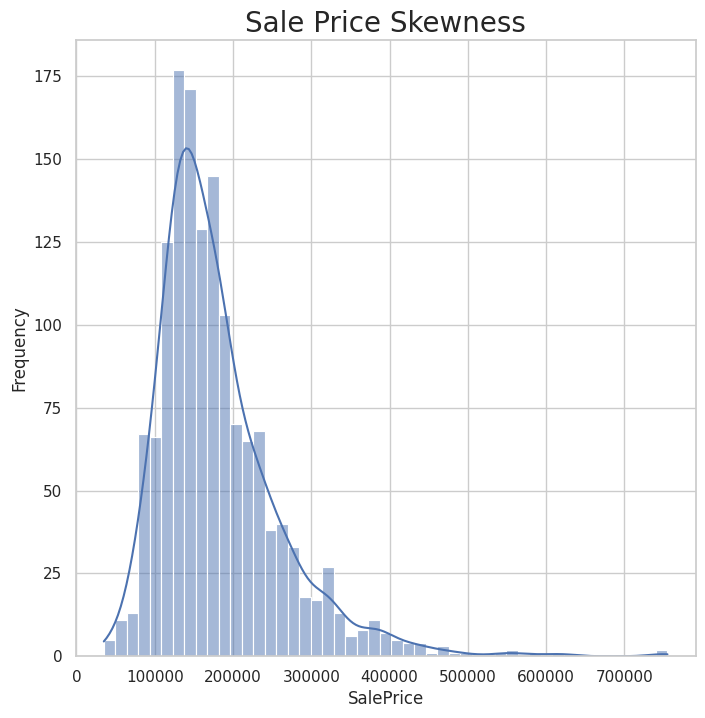

In [105]:
plt.figure(figsize=(8,8))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Sale Price Skewness', fontsize=20)
plt.ylabel('Frequency')
plt.show()

In [61]:
print(train['SalePrice'].skew())

1.8828757597682129


SalePrice contains <span style='color:blue'> high right skewness </span>

### Check for correlation

In [79]:
correlations = (
        num_df
        .corr()
)

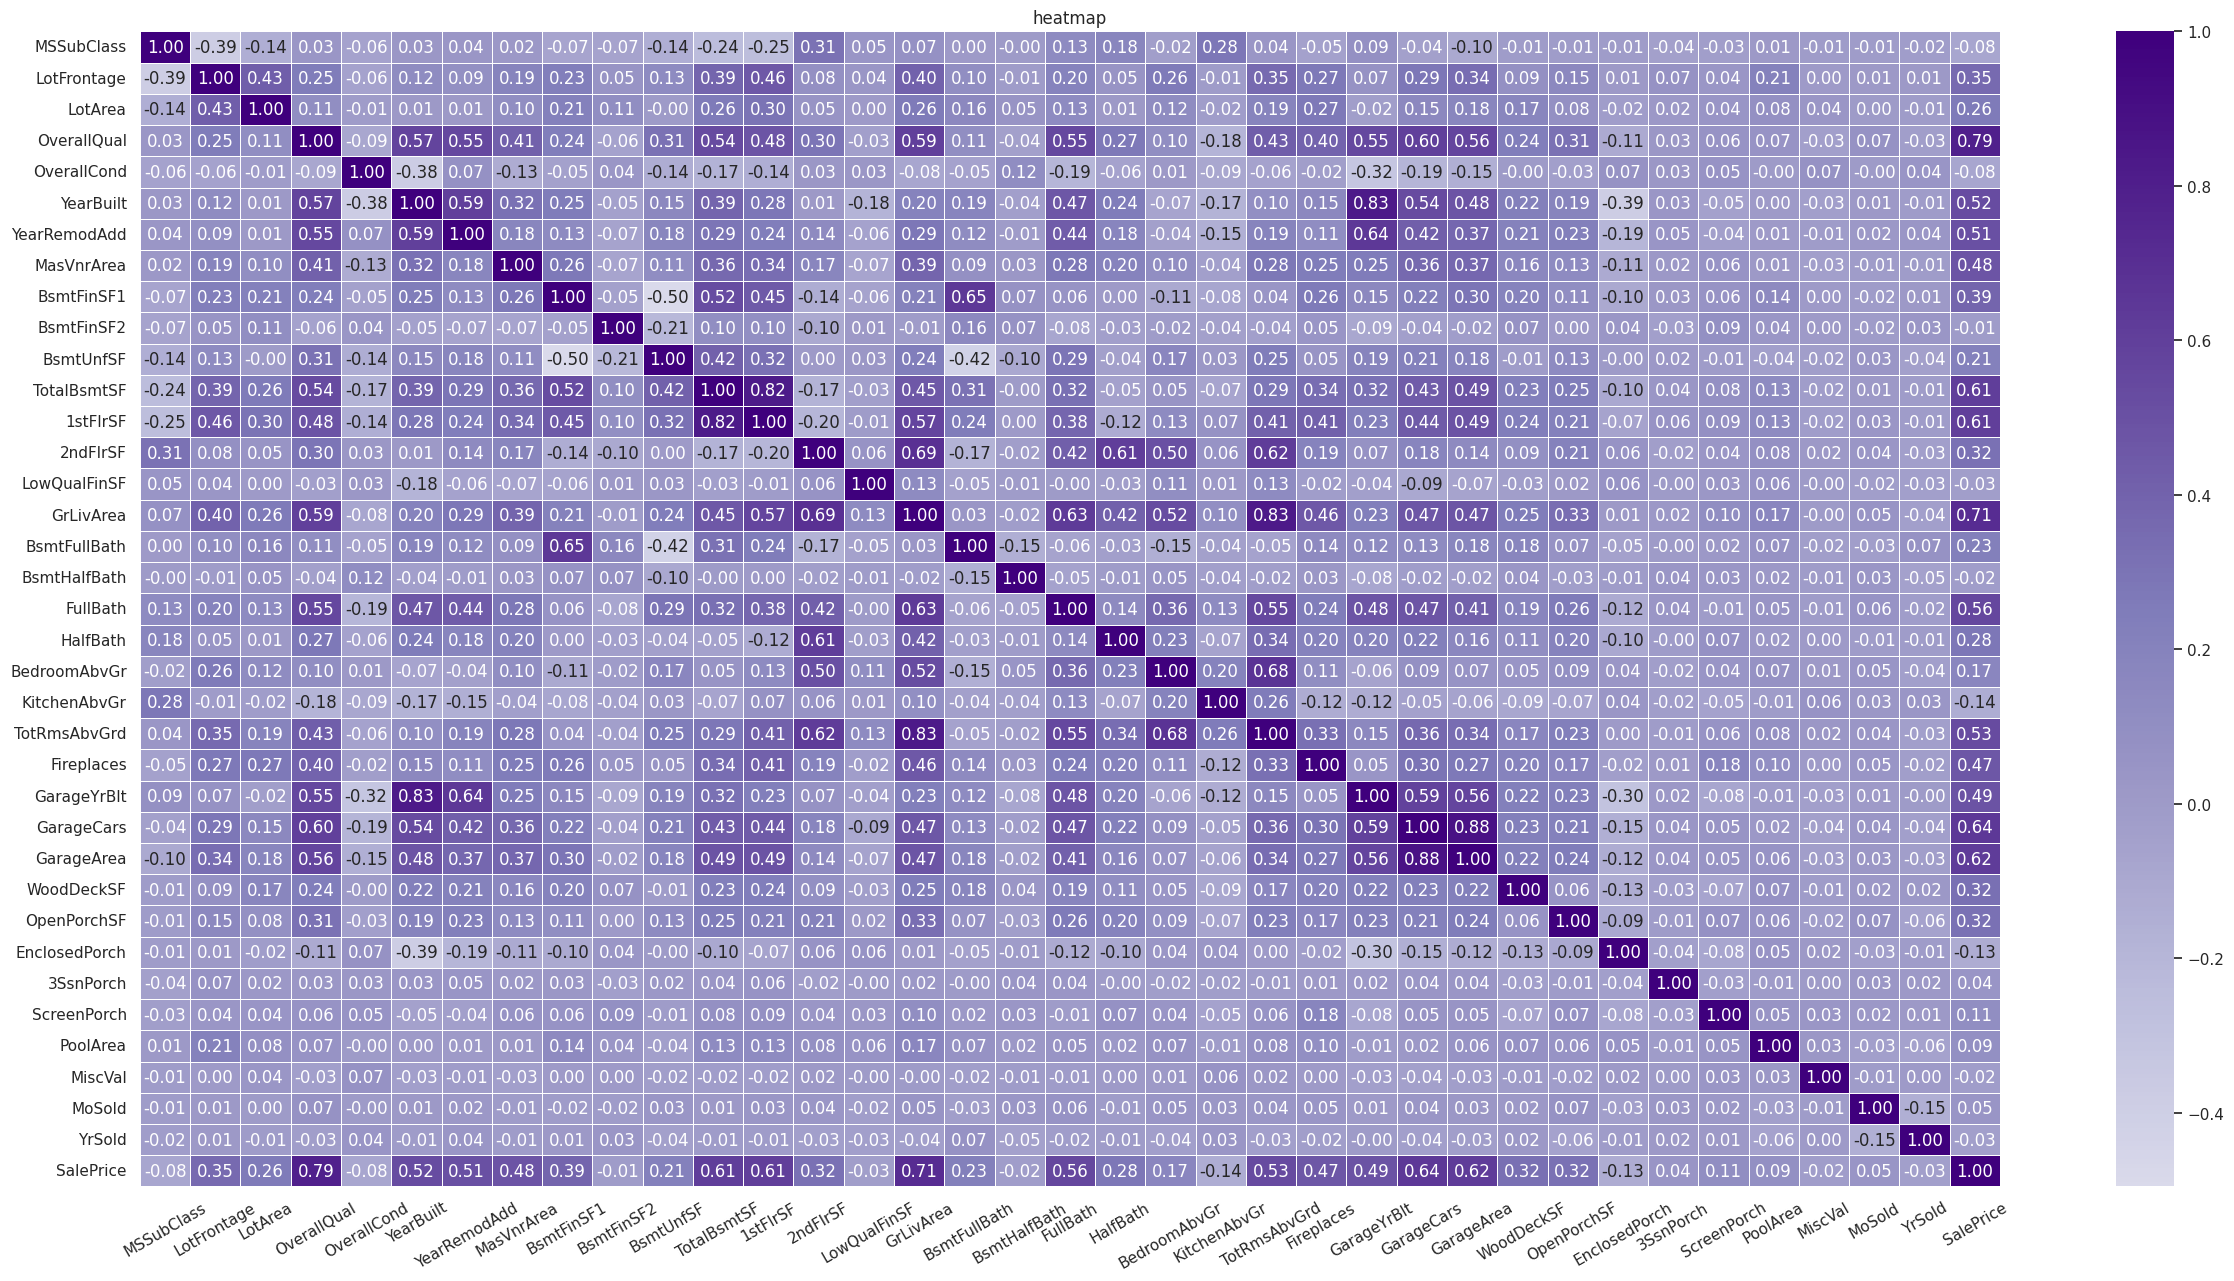

In [110]:
_plt('heat', correlations)

Remod is a good feature that will be more useful for us if it's just 1 (remodelling was done), or 0 (no remodelling done)

In [53]:
train_copy['MSSubClass'] = train_copy['MSSubClass'].astype(str)

Using the numericals variable to get a correlation matrix

In [4]:
num_features = ['LotArea', 'OverallQual', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 
               'Age']

---

Let's save the train_copy dataframe to a csv

In [86]:
train_copy.to_csv("house-pricing-data/train_copy.csv", index=False)

In [7]:
df = pd.read_csv('house-pricing-data/train_copy.csv')
df['MSSubClass'] = df['MSSubClass'].astype(str)
df.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1         60       RL         65.0     8450   Pave  NoAl      Reg   
1   2         20       RL         80.0     9600   Pave  NoAl      Reg   
2   3         60       RL         68.0    11250   Pave  NoAl      IR1   
3   4         70       RL         60.0     9550   Pave  NoAl      IR1   
4   5         60       RL         84.0    14260   Pave  NoAl      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YrBuilt  Remod  \
0       Norm     1Fam     2Story            7            5     2003      0   
1       Norm     1Fam     1Story            6            8     1976      0   
2       Norm     1Fam     2Story            7            5     2001      1   
3       Norm     1Fam     2Story            7            5     1915      1   
4       Norm     1Fam     2Story            8            5     2000      0   

  RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd   
1     Gable  CompShg     MetalSd     MetalSd      NoVnr         0.0        TA   
2     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd   
3     Gable  CompShg     Wd Sdng     Wd Shng      NoVnr         0.0        TA   
4     Gable  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd   

  ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        TA      PConc       Gd       TA           No          GLQ   
1        TA     CBlock       Gd       TA           Gd          ALQ   
2        TA      PConc       Gd       TA           Mn          GLQ   
3        TA     BrkTil       TA       Gd           No          ALQ   
4        TA      PConc       Gd       TA           Av          GLQ   

   BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0         706          Unf           0        150          856    GasA   
1         978          Unf           0        284         1262    GasA   
2         486          Unf           0        434          920    GasA   
3         216          Unf           0        540          756    GasA   
4         655          Unf           0        490         1145    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr       856       854             0   
1        Ex          Y      SBrkr      1262         0             0   
2        Ex          Y      SBrkr       920       866             0   
3        Gd          Y      SBrkr       961       756             0   
4        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        NoFi   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           1          Gd   
4             1    

In [8]:
encoding_feats = {'Nominal': ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 'Neighborhood', 
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
                'SaleType', 'SaleCondition'], 
                  'Ordinal': ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
               'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']}

In [10]:
nominal_encoded = pd.get_dummies(df[encoding_feats['Nominal']], dtype=float)
df_encoded = pd.concat([df, nominal_encoded], axis=1)
df_encoded = df_encoded.drop(df[encoding_feats['Nominal']].columns, axis=1)
df_encoded.head()

Id  LotFrontage  LotArea LotShape LandContour LandSlope  OverallQual  \
0   1         65.0     8450      Reg         Lvl       Gtl            7   
1   2         80.0     9600      Reg         Lvl       Gtl            6   
2   3         68.0    11250      IR1         Lvl       Gtl            7   
3   4         60.0     9550      IR1         Lvl       Gtl            7   
4   5         84.0    14260      IR1         Lvl       Gtl            8   

   OverallCond  YrBuilt  Remod  MasVnrArea ExterQual ExterCond BsmtQual  \
0            5     2003      0       196.0        Gd        TA       Gd   
1            8     1976      0         0.0        TA        TA       Gd   
2            5     2001      1       162.0        Gd        TA       Gd   
3            5     1915      1         0.0        TA        TA       TA   
4            5     2000      0       350.0        Gd        TA       Gd   

  BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
0       TA           No          GLQ         706          Unf           0   
1       TA           Gd          ALQ         978          Unf           0   
2       TA           Mn          GLQ         486          Unf           0   
3       Gd           No          ALQ         216          Unf           0   
4       TA           Av          GLQ         655          Unf           0   

   BsmtUnfSF  TotalBsmtSF HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        150          856        Ex       856       854             0   
1        284         1262        Ex      1262         0             0   
2        434          920        Ex       920       866             0   
3        540          756        Gd       961       756             0   
4        490         1145        Ex      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        NoFi   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           1          Gd   
4             1          Gd             9        Typ           1          TA   

   GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond  \
0       2003.0          RFn           2         548         TA         TA   
1       1976.0          RFn           2         460         TA         TA   
2       2001.0          RFn           2         608         TA         TA   
3       1998.0          Unf           3         642         TA         TA   
4       2000.0          RFn           3         836         TA         TA   

  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0          Y           0           61              0          0            0   
1          Y         298            0              0          0            0   
2          Y           0           42              0          0            0   
3          Y           0           35            272          0            0   
4          Y         192           84              0          0            0   

   PoolArea PoolQC Fence  MiscVal  MoSold  YrSold  SalePrice  Age  \
0         0   NoPl  NoFc        0       2    2008     208500    5   
1         0   NoPl  NoFc        0       5    2007     181500   31   
2         0   NoPl  NoFc        0       9    2008     223500    7   
3         0   NoPl  NoFc     

In [11]:
for i in df[encoding_feats['Ordinal']].columns:
    print(i, df[i].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'Nb' 'Fa']
BsmtCond ['TA' 'Gd' 'Nb' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'Nb']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Nb' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'Nb' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
FireplaceQu ['NoFi' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'NoG']
GarageQual ['TA' 'Fa' 'Gd' 'NoG' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'NoG' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']
PoolQC ['NoPl' 'Ex' 'Fa' 'Gd']
Fence ['NoFc' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [12]:
ordinal_feats_order = [
    ['Reg', 'IR1', 'IR2', 'IR3'],                   # LotShape
    ['Low', 'HLS', 'Bnk', 'Lvl'],                   # LandContour  
    ['Gtl', 'Mod', 'Sev'],                          # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterCond
    ['Nb', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],           # BsmtQual (Nb = No basement)
    ['Nb', 'Po', 'Fa', 'TA', 'Gd'],                 # BsmtCond
    ['Nb', 'No', 'Mn', 'Av', 'Gd'],                 # BsmtExposure
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType1
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # KitchenQual
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['NoFi', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],         # FireplaceQu
    ['NoG', 'Unf', 'RFn', 'Fin'],                   # GarageFinish
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageQual
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageCond
    ['N', 'P', 'Y'],                                # PavedDrive
    ['NoPl', 'Fa', 'Gd', 'Ex'],                     # PoolQC
    ['NoFc', 'MnWw', 'MnPrv', 'GdWo', 'GdPrv']      # Fence
]

In [13]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_enc = OrdinalEncoder(categories=ordinal_feats_order, handle_unknown='use_encoded_value', unknown_value=-1 )

encoded_ordinals = ordinal_enc.fit_transform(df[encoding_feats['Ordinal']])

df_encoded[encoding_feats['Ordinal']] = encoded_ordinals

In [14]:
df_encoded.head()

Id  LotFrontage  LotArea  LotShape  LandContour  LandSlope  OverallQual  \
0   1         65.0     8450       0.0          3.0        0.0            7   
1   2         80.0     9600       0.0          3.0        0.0            6   
2   3         68.0    11250       1.0          3.0        0.0            7   
3   4         60.0     9550       1.0          3.0        0.0            7   
4   5         84.0    14260       1.0          3.0        0.0            8   

   OverallCond  YrBuilt  Remod  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
0            5     2003      0       196.0        3.0        2.0       4.0   
1            8     1976      0         0.0        2.0        2.0       4.0   
2            5     2001      1       162.0        3.0        2.0       4.0   
3            5     1915      1         0.0        2.0        2.0       3.0   
4            5     2000      0       350.0        3.0        2.0       4.0   

   BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0       3.0           1.0           6.0         706           1.0           0   
1       3.0           4.0           5.0         978           1.0           0   
2       3.0           2.0           6.0         486           1.0           0   
3       4.0           1.0           5.0         216           1.0           0   
4       3.0           3.0           6.0         655           1.0           0   

   BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        150          856        4.0       856       854             0   
1        284         1262        4.0      1262         0             0   
2        434          920        4.0       920       866             0   
3        540          756        3.0       961       756             0   
4        490         1145        4.0      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
0             1          3.0             8         6.0           0   
1             1          2.0             6         6.0           1   
2             1          3.0             6         6.0           1   
3             1          3.0             7         6.0           1   
4             1          3.0             9         6.0           1   

   FireplaceQu  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  \
0          0.0       2003.0           2.0           2         548         3.0   
1          3.0       1976.0           2.0           2         460         3.0   
2          3.0       2001.0           2.0           2         608         3.0   
3          4.0       1998.0           1.0           3         642         3.0   
4          3.0       2000.0           2.0           3         836         3.0   

   GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         3.0         2.0           0           61              0          0   
1         3.0         2.0         298            0              0          0   
2         3.0         2.0           0           42              0          0   
3         3.0         2.0           0           35            272          0   
4         3.0         2.0         192           84              0          0   

   ScreenPorch  PoolArea  PoolQC  Fence  MiscVal  MoSold  YrSold  SalePrice  \
0            0         0     0.0    0.0        0       2    2008     208500   
1            0         0     0.0    0.0        0       5    2007     181500   
2            0         0     0.0    0.

In [15]:
print('original df shape, rows: ', df.shape[0], ', columns: ', df.shape[1])

print('encoded df shape, rows: ', df_encoded.shape[0], ', columns: ', df_encoded.shape[1])

original df shape, rows:  1460 , columns:  81
encoded df shape, rows:  1460 , columns:  235


---
Now that every column is encoded, we can proceed to do the modelling.  
But before that we'll do some EDA on the non-encoded data frame.


In [17]:
# original non-encoded data frame
df.head(3)

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1         60       RL         65.0     8450   Pave  NoAl      Reg   
1   2         20       RL         80.0     9600   Pave  NoAl      Reg   
2   3         60       RL         68.0    11250   Pave  NoAl      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YrBuilt  Remod  \
0       Norm     1Fam     2Story            7            5     2003      0   
1       Norm     1Fam     1Story            6            8     1976      0   
2       Norm     1Fam     2Story            7            5     2001      1   

  RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd   
1     Gable  CompShg     MetalSd     MetalSd      NoVnr         0.0        TA   
2     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd   

  ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        TA      PConc       Gd       TA           No          GLQ   
1        TA     CBlock       Gd       TA           Gd          ALQ   
2        TA      PConc       Gd       TA           Mn          GLQ   

   BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0         706          Unf           0        150          856    GasA   
1         978          Unf           0        284         1262    GasA   
2         486          Unf           0        434          920    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr       856       854             0   
1        Ex          Y      SBrkr      1262         0             0   
2        Ex          Y      SBrkr       920       866             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        NoFi   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       2003.0          RFn           2         548         TA   
1     Attchd       1976.0          RFn           2         460         TA   
2     Attchd       2001.0          RFn           2         608         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y           0           61              0          0   
1         TA          Y         298            0              0          0   
2         TA          Y           0           42              0          0   

   ScreenPorch  PoolArea PoolQC Fence  MiscVal  MoSold  YrSold SaleType  \
0            0         0   NoPl  NoFc        0       2    2008       WD   
1            0         0   NoPl  NoFc        0       5    2007       WD   
2            0         0   NoPl  NoFc        0       9    2008       WD   

  SaleCondition  SalePrice  Age  
0        Normal     208500    5  
1        Normal     181500   31  
2        Normal     223500    7

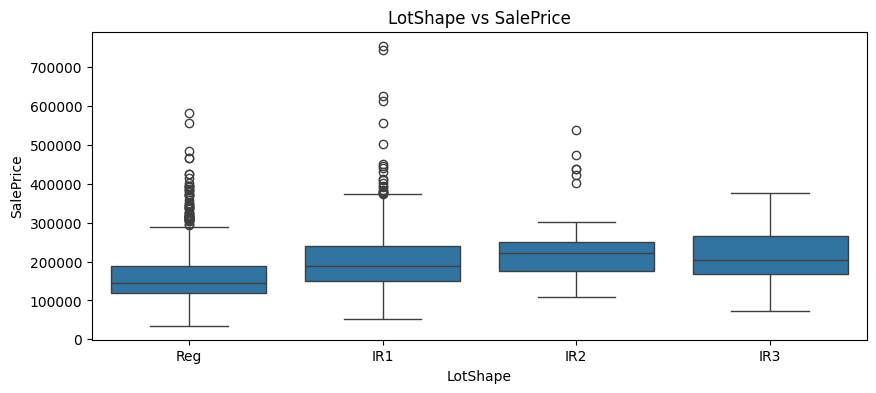

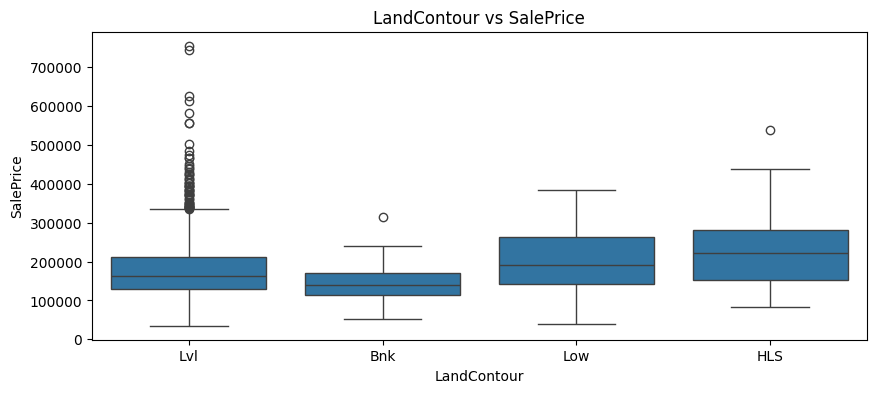

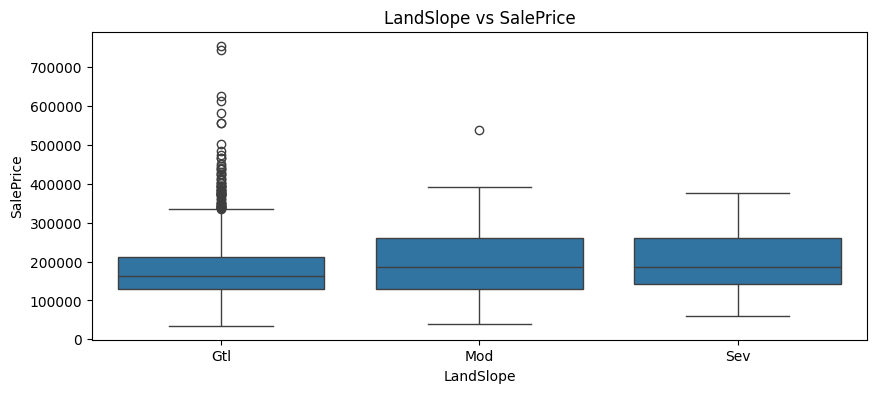

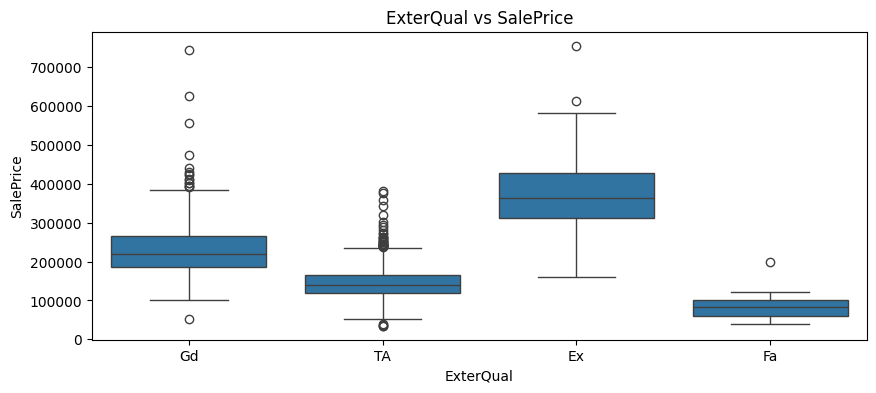

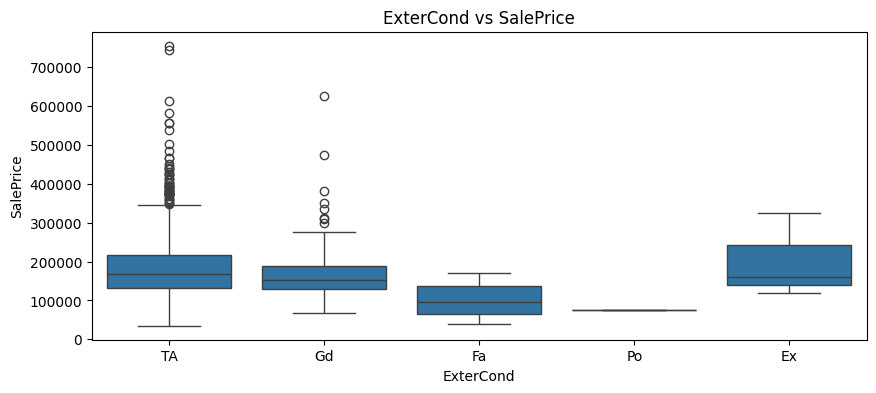

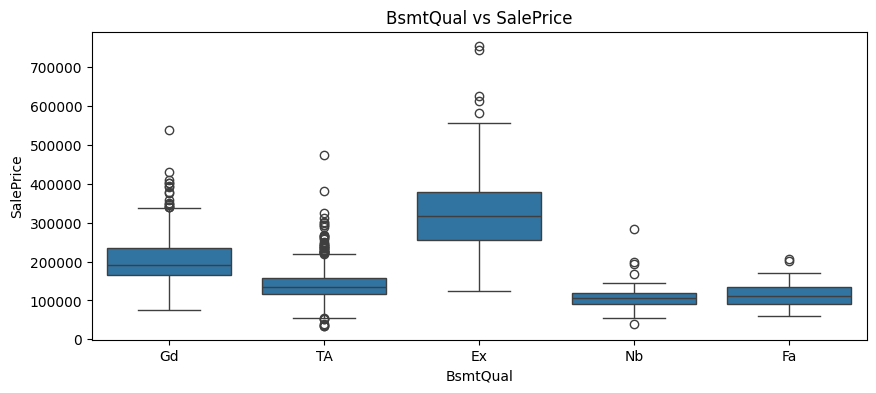

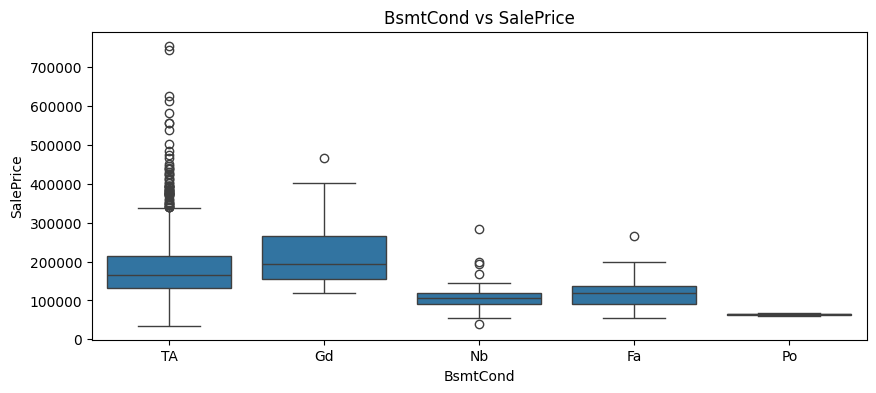

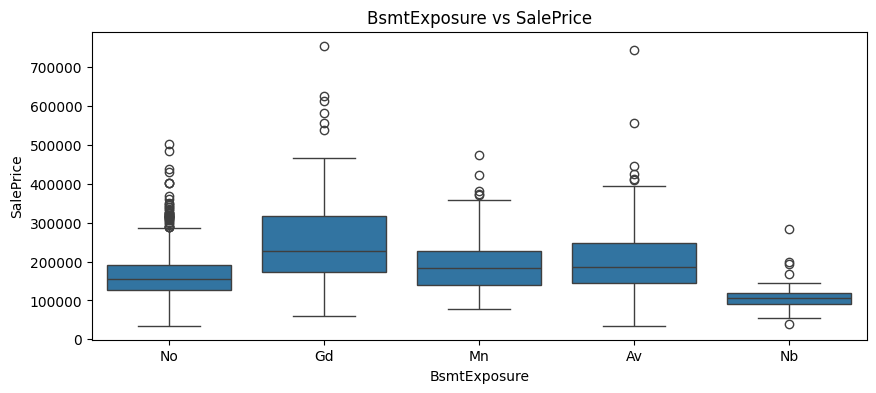

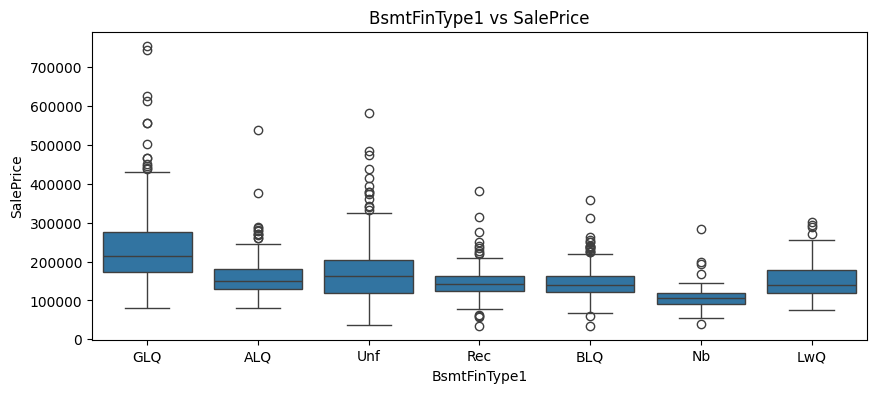

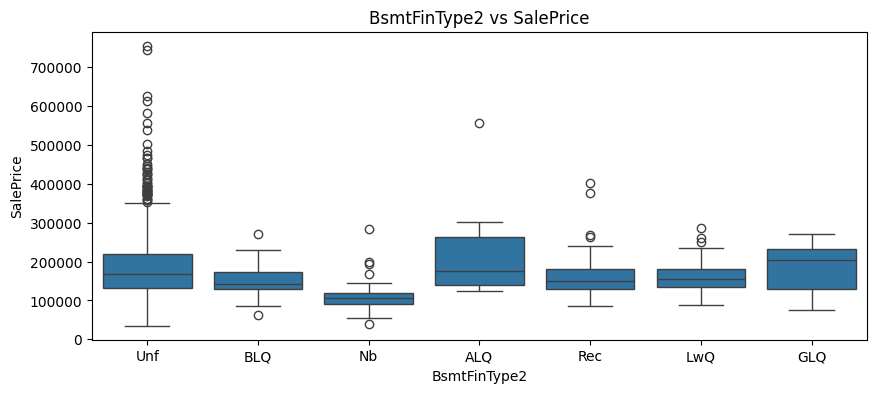

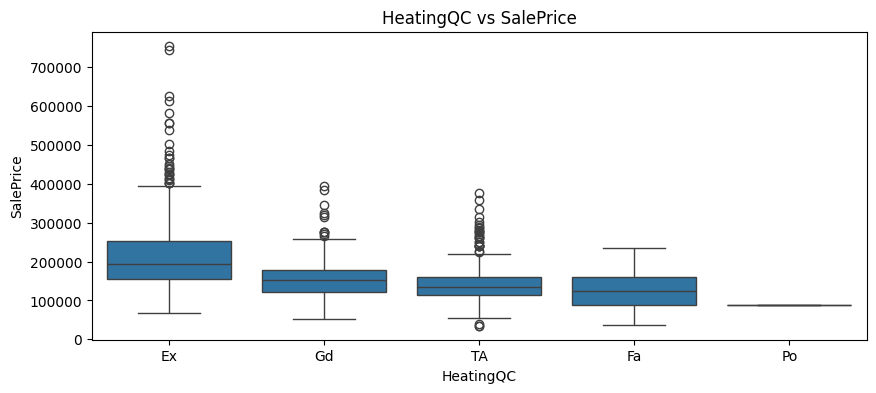

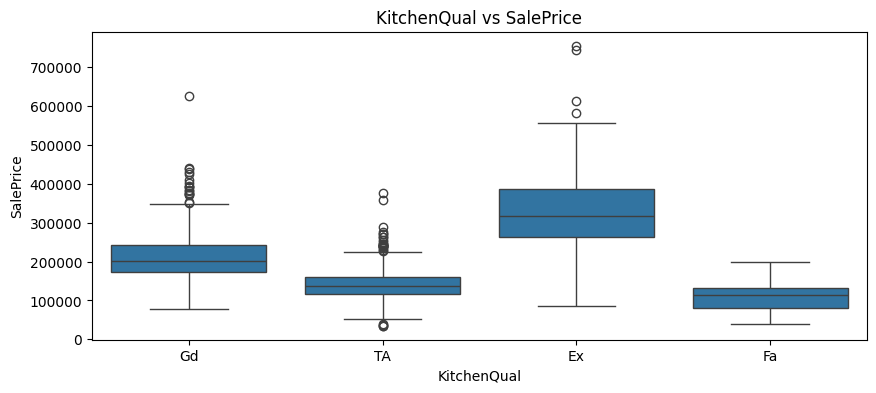

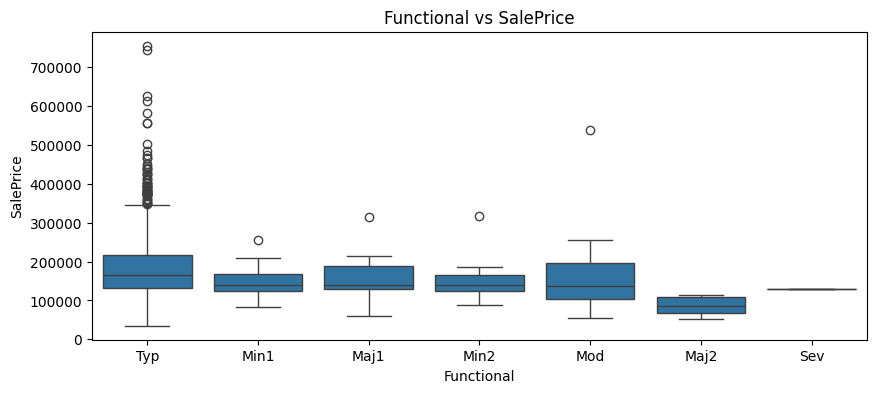

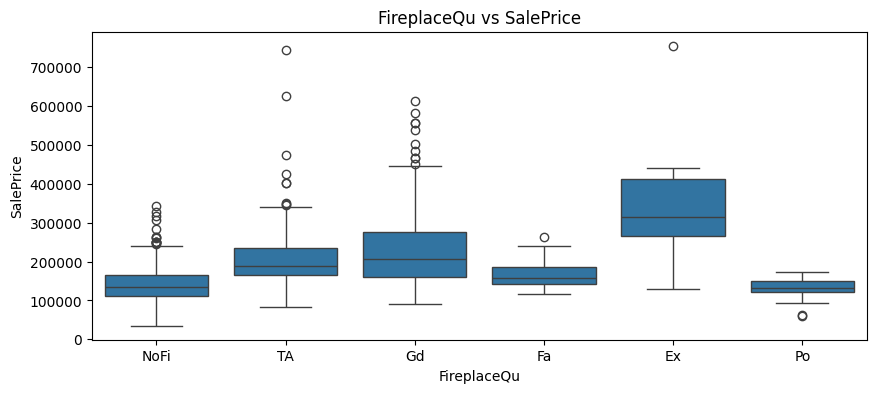

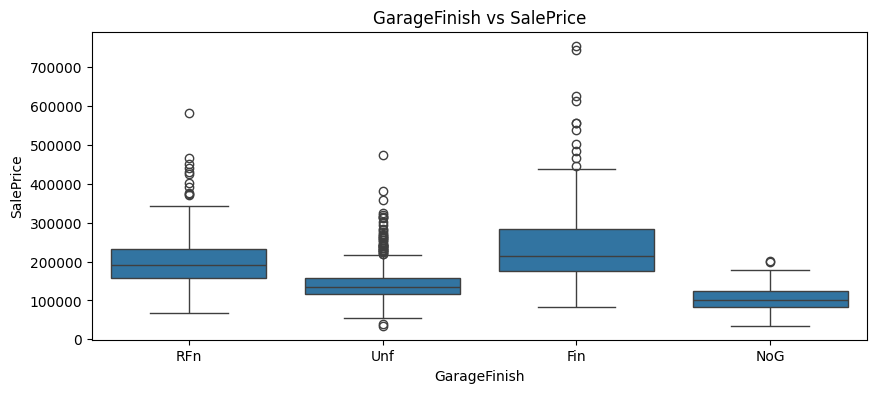

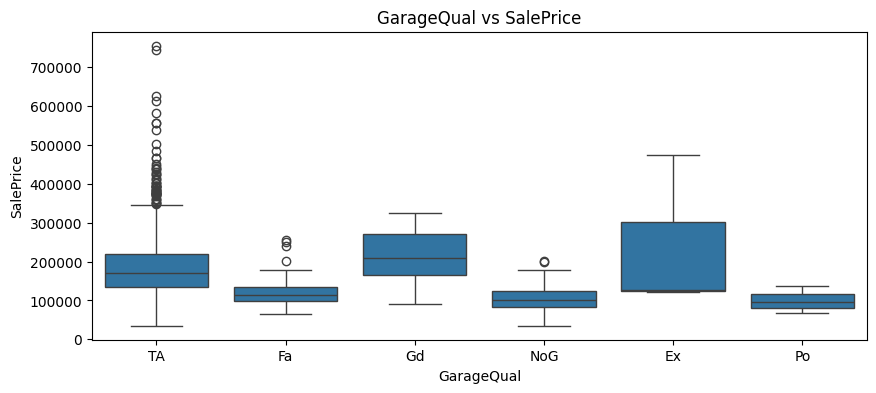

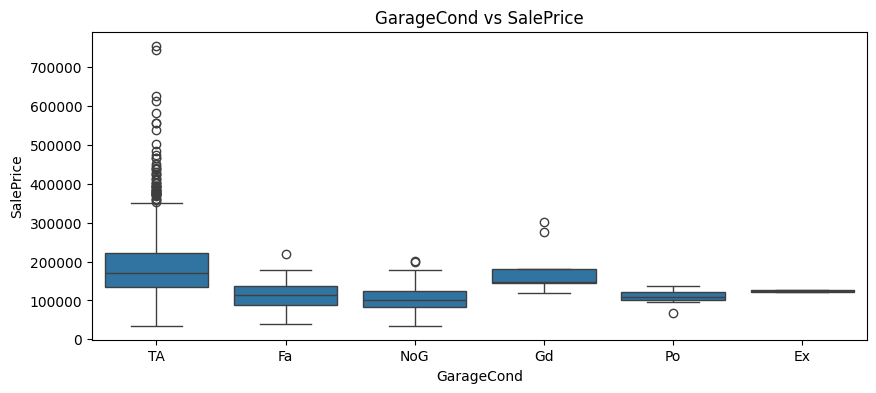

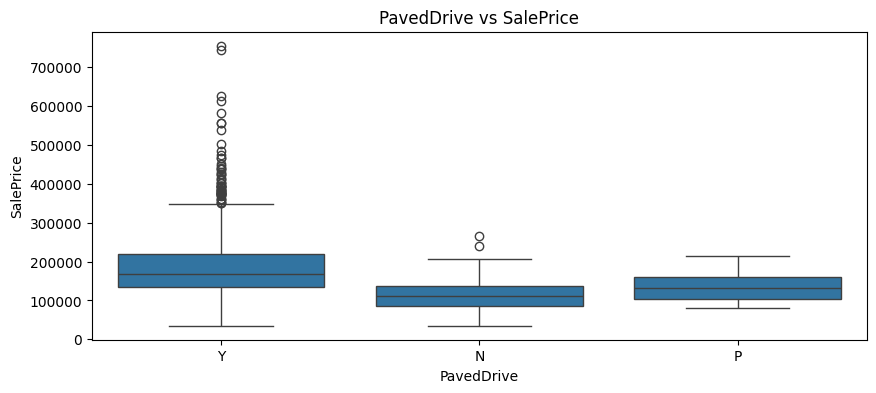

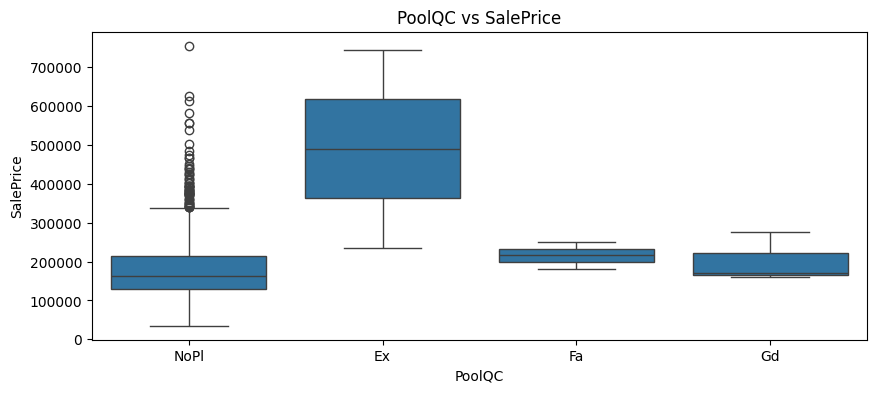

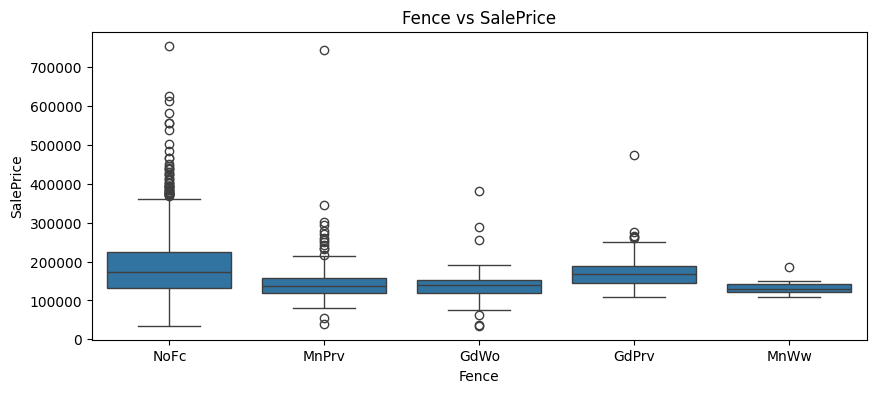

In [85]:
for col in encoding_feats['Ordinal']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col], y=df['SalePrice'])  # Use original categories
    plt.title(f'{col} vs SalePrice')
    plt.show()

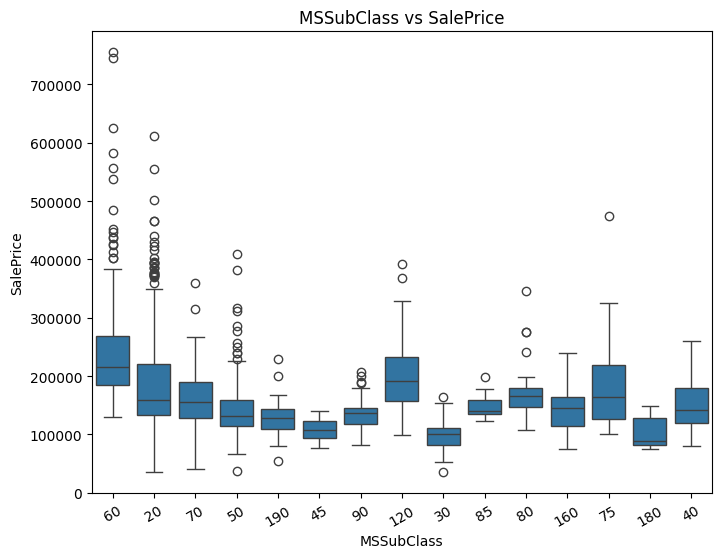

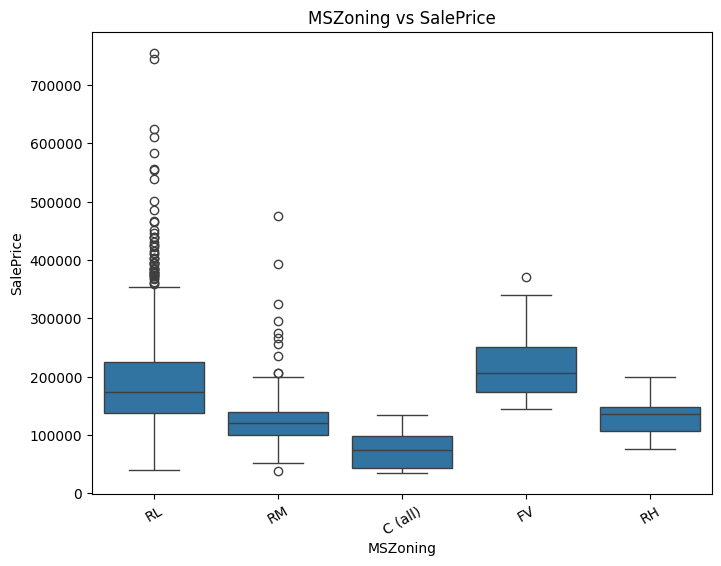

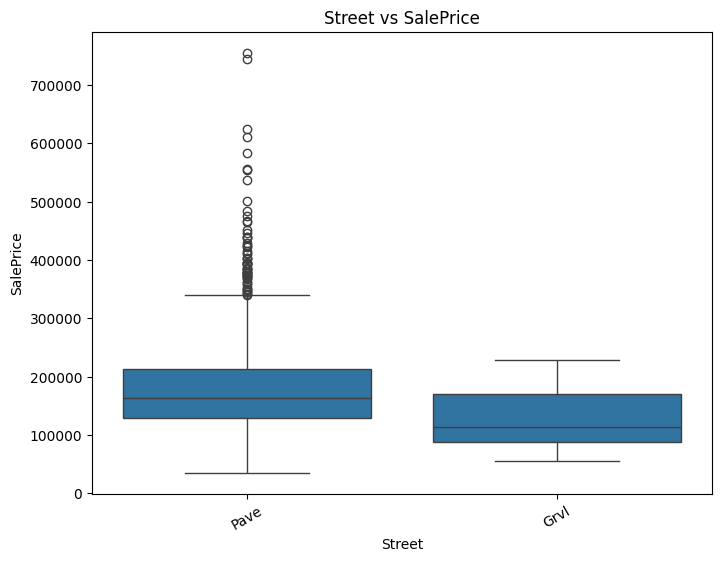

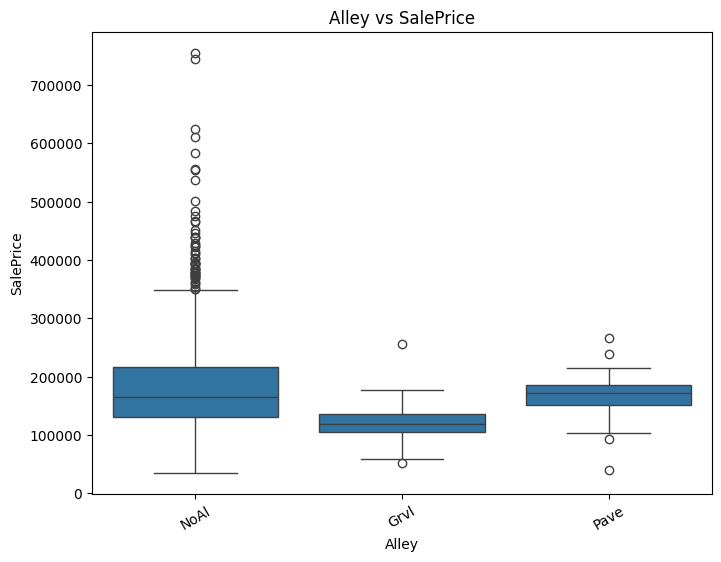

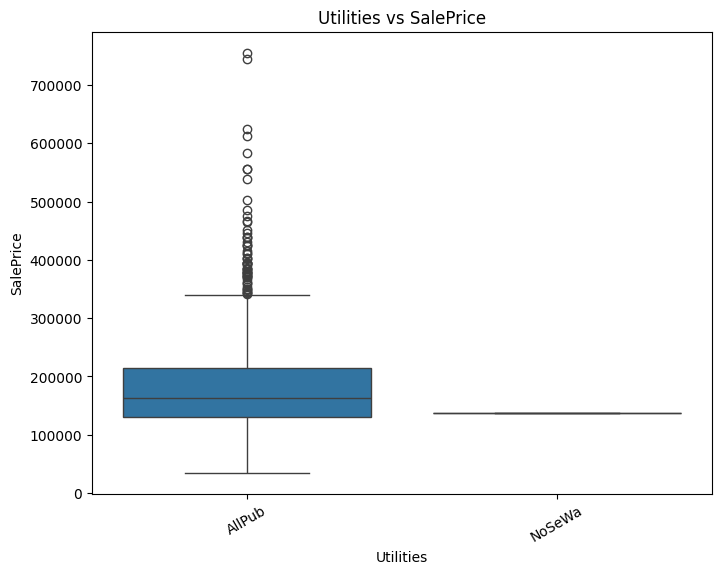

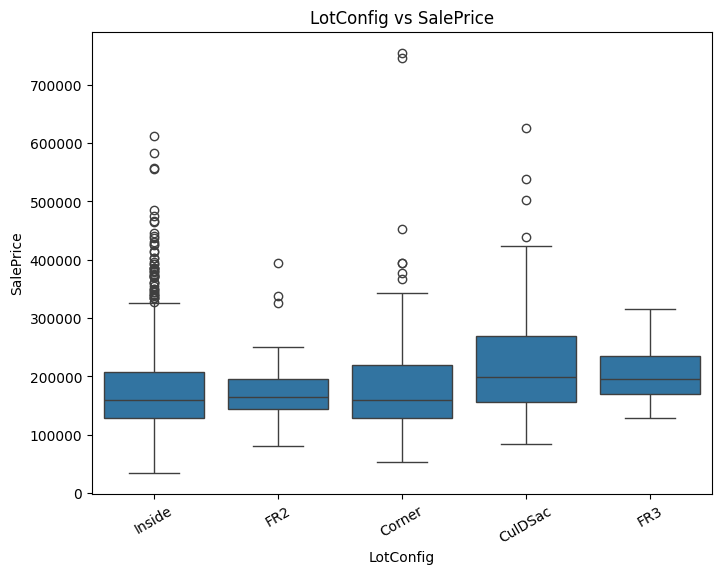

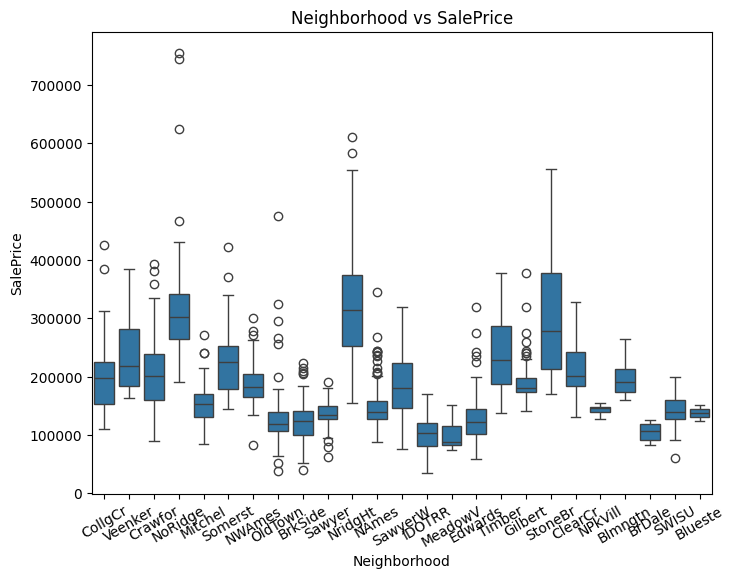

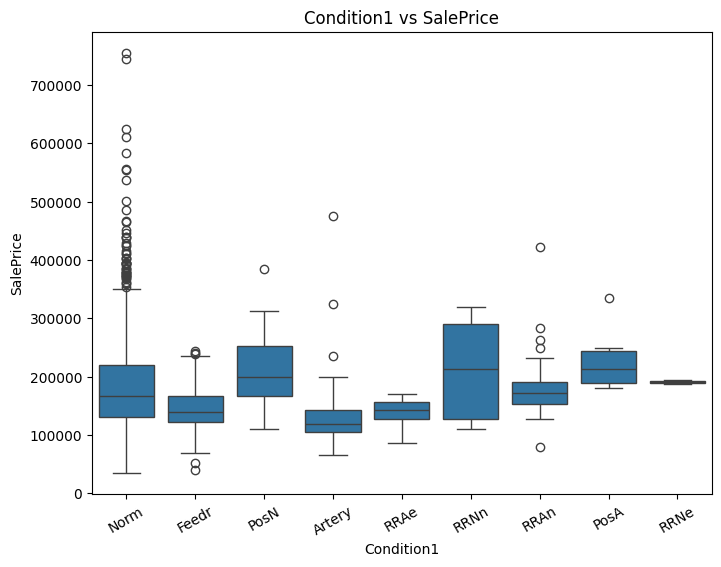

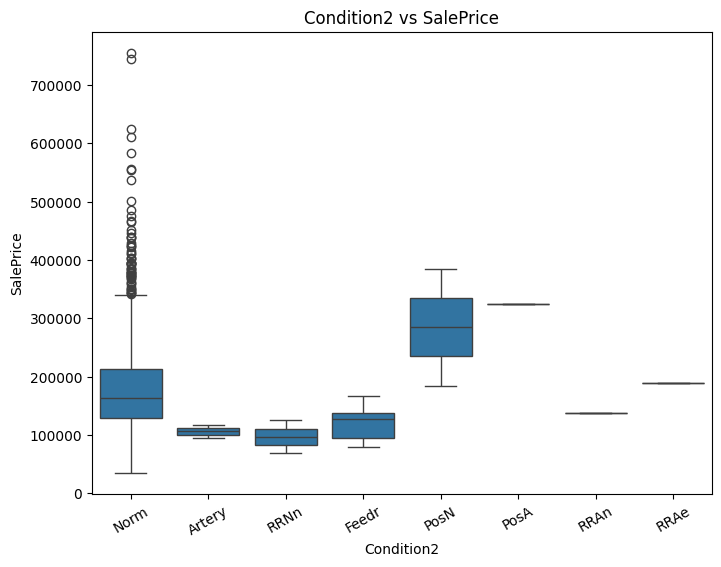

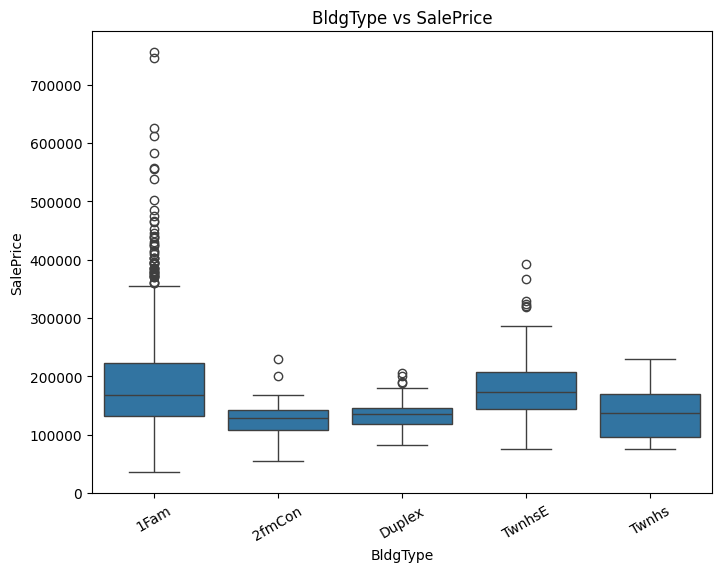

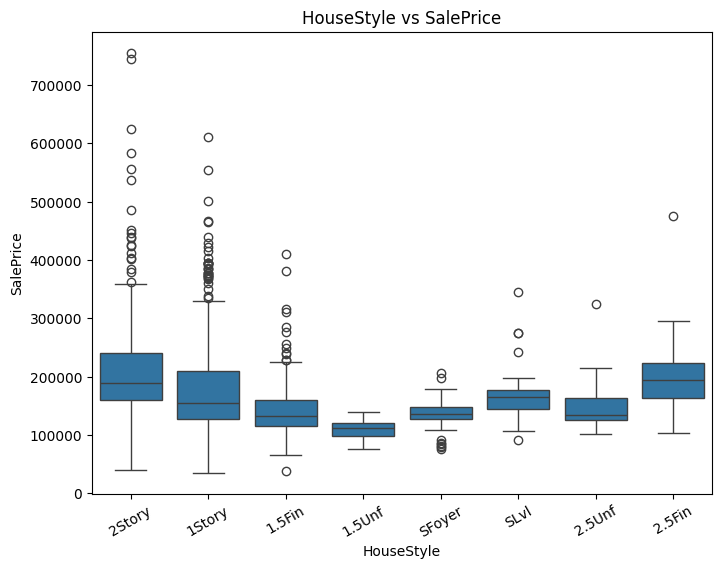

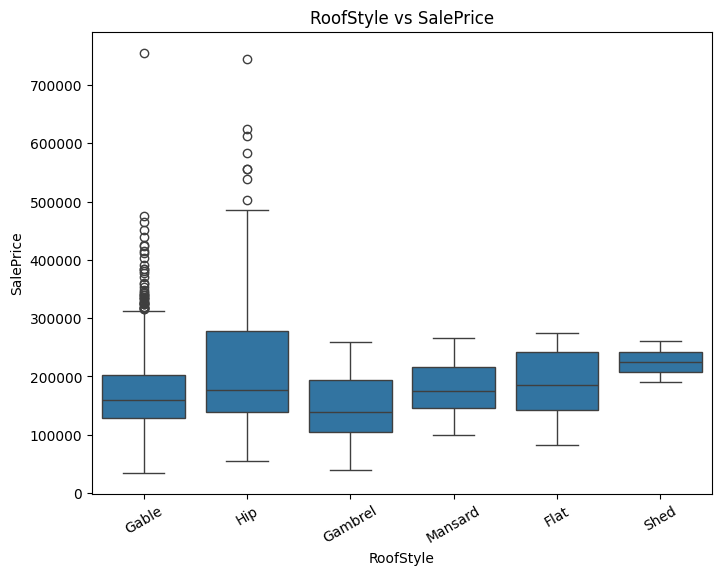

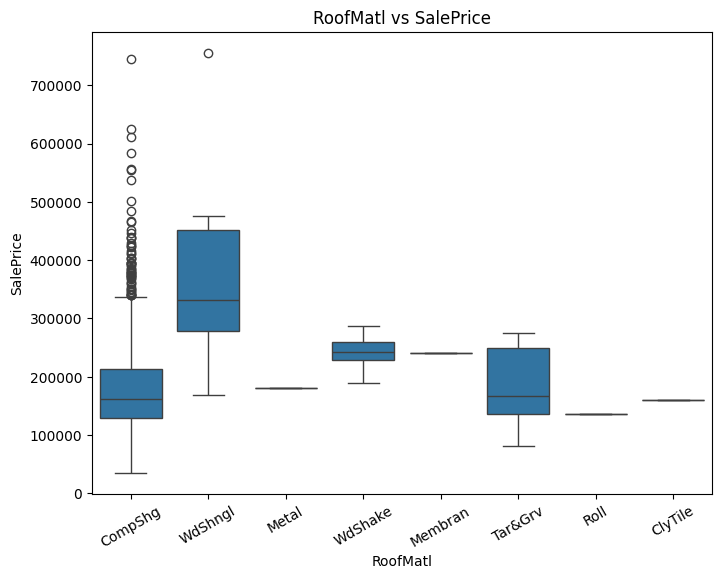

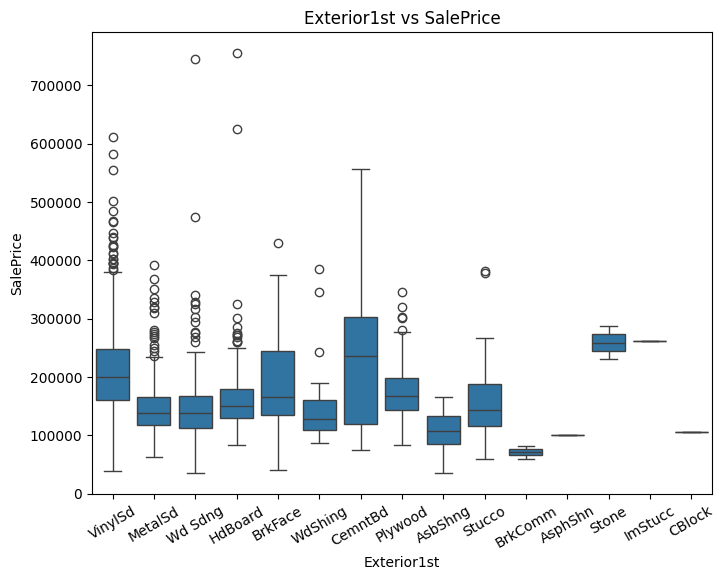

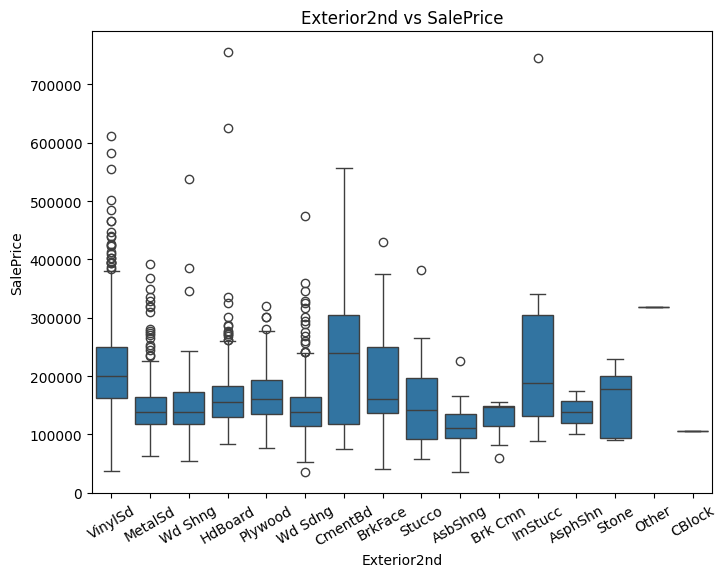

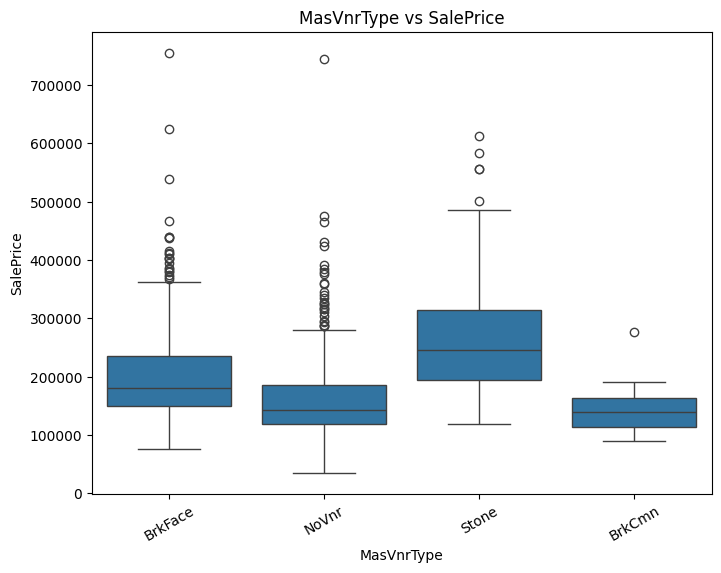

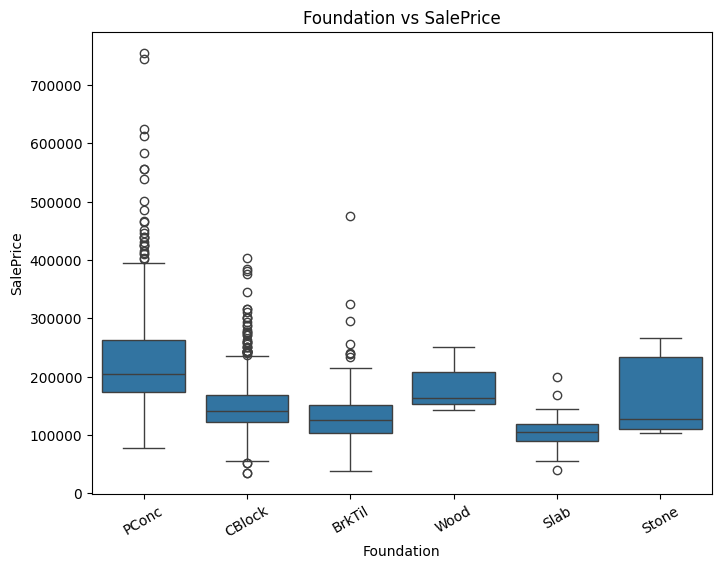

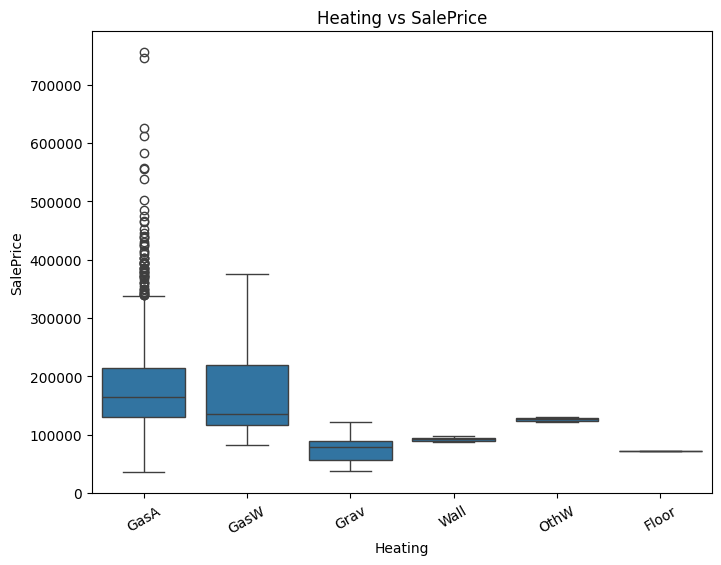

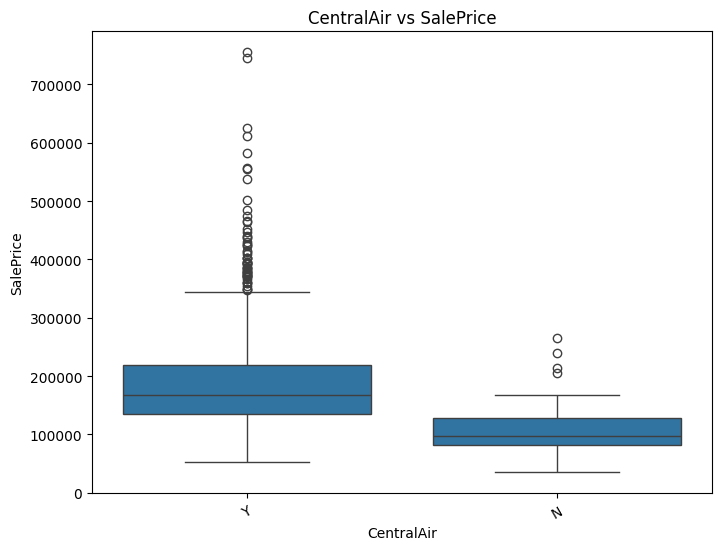

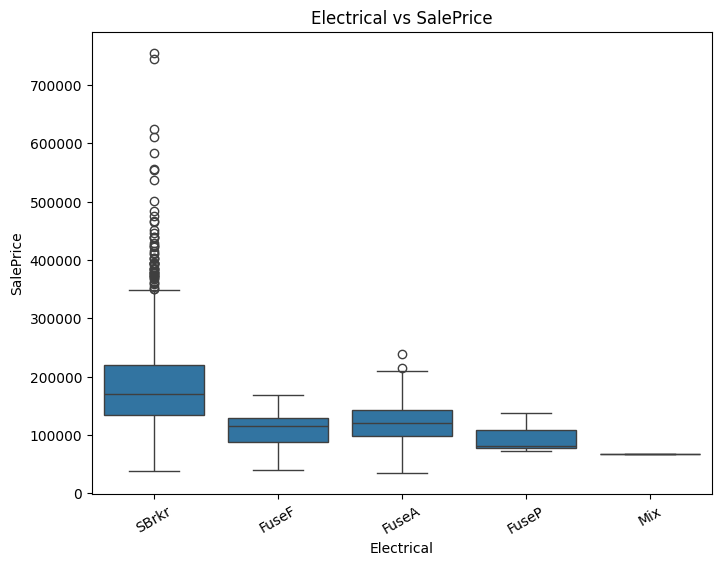

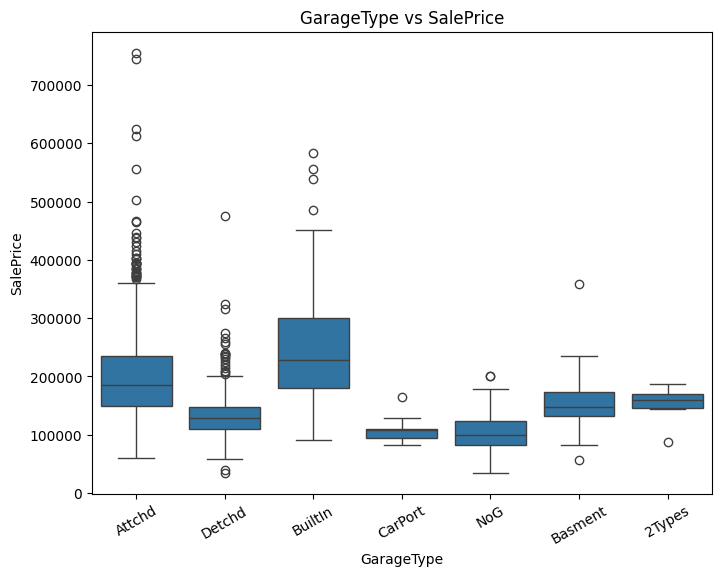

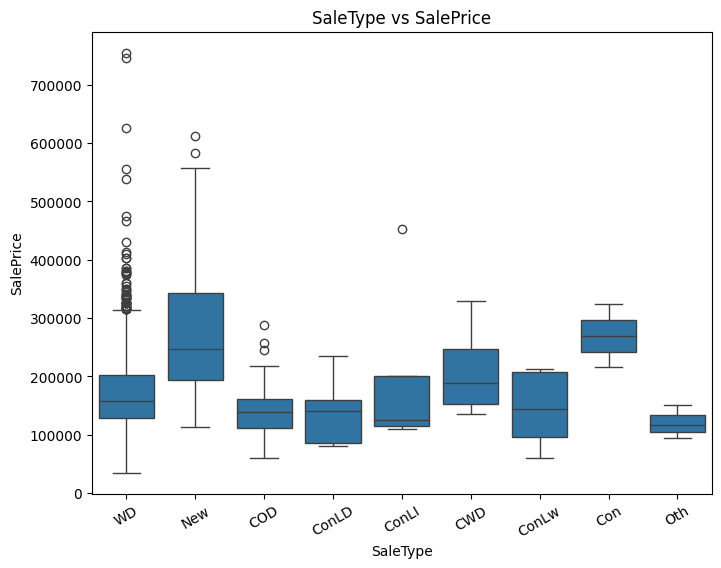

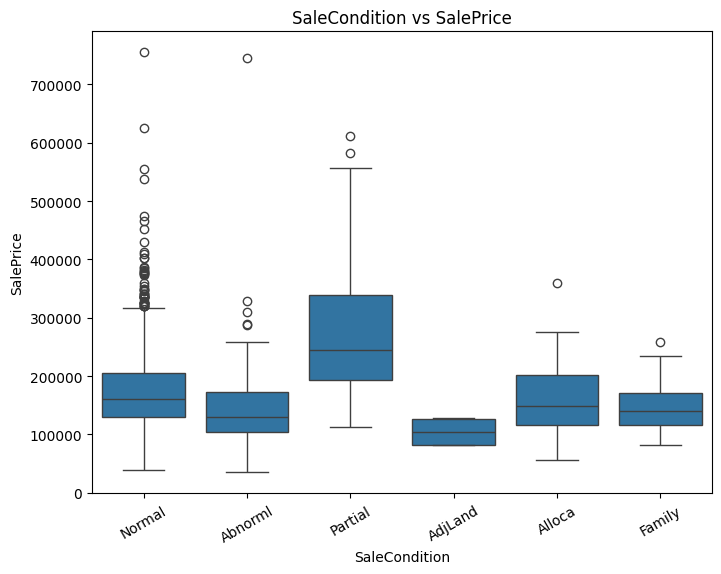

In [21]:
for col in encoding_feats['Nominal']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col], y=df['SalePrice'])  # Use original categories
    plt.xticks(rotation=30)
    plt.title(f'{col} vs SalePrice')
    plt.show()

False


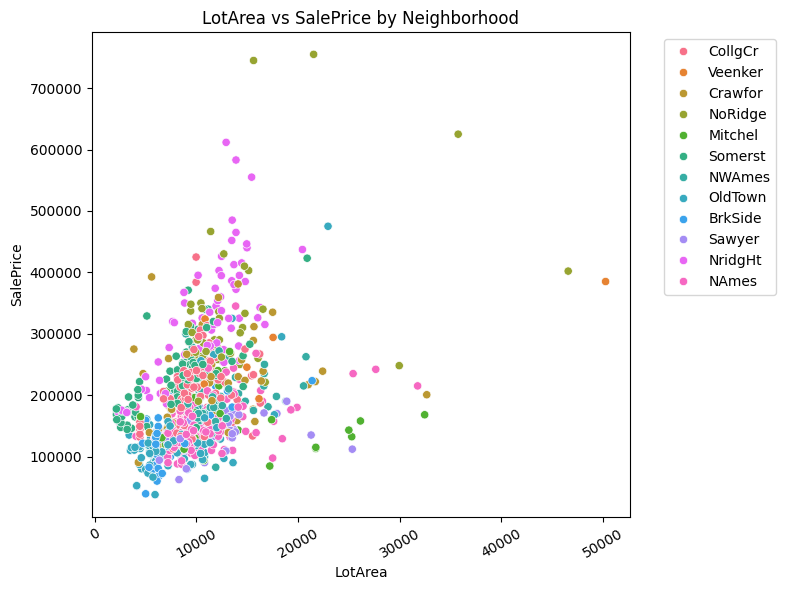

False


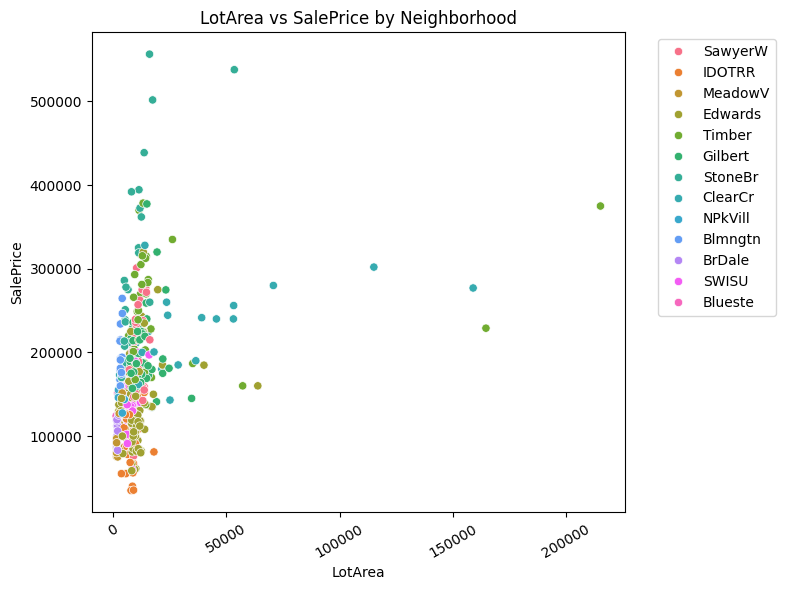

In [155]:
x_val = 'LotArea'
y_val = 'SalePrice'
hue_val = 'Neighborhood'

# get unique hue values
unique_hues = df[hue_val].unique()
midpoint = len(unique_hues) // 2

# separate the hue values
first_half_hues = unique_hues[:midpoint]
second_half_hues = unique_hues[midpoint:]

# filter dataframes
df_first = df[df[hue_val].isin(first_half_hues)]
df_second = df[df[hue_val].isin(second_half_hues)]

# Plot first half
_plt('scatter', df_first, x_val, y_val, hue_val)

# Plot second half
_plt('scatter', df_second, x_val, y_val, hue_val)

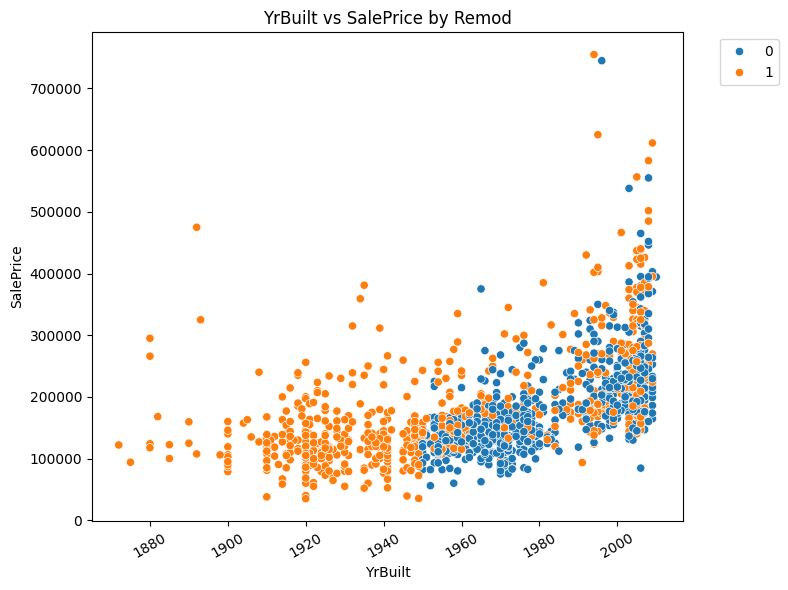

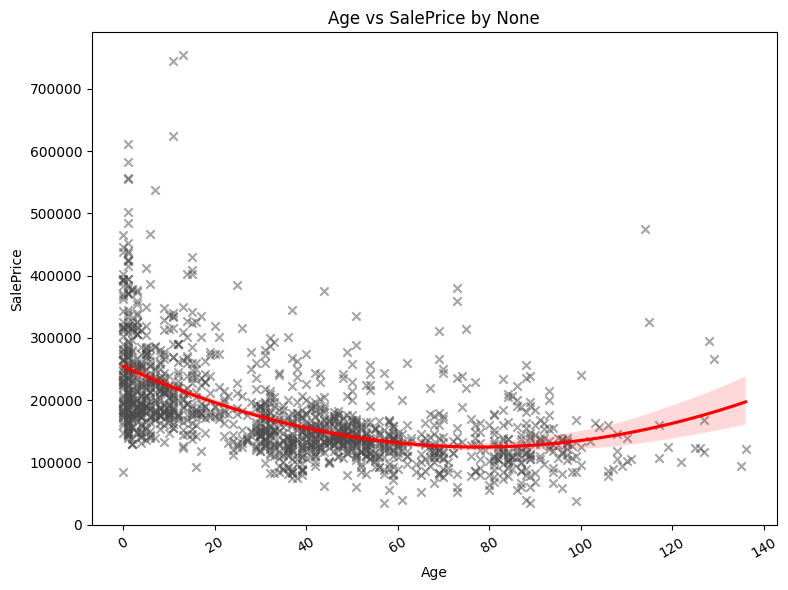

In [186]:
# sale prices by year ; sale prices by year and if they had remodelling done
_plt(plt_type='scatter', df_slice=df, x_val='YrBuilt', y_val='SalePrice', hue_val='Remod')
_plt(plt_type='reg', df_slice=df, x_val='Age', y_val='SalePrice')

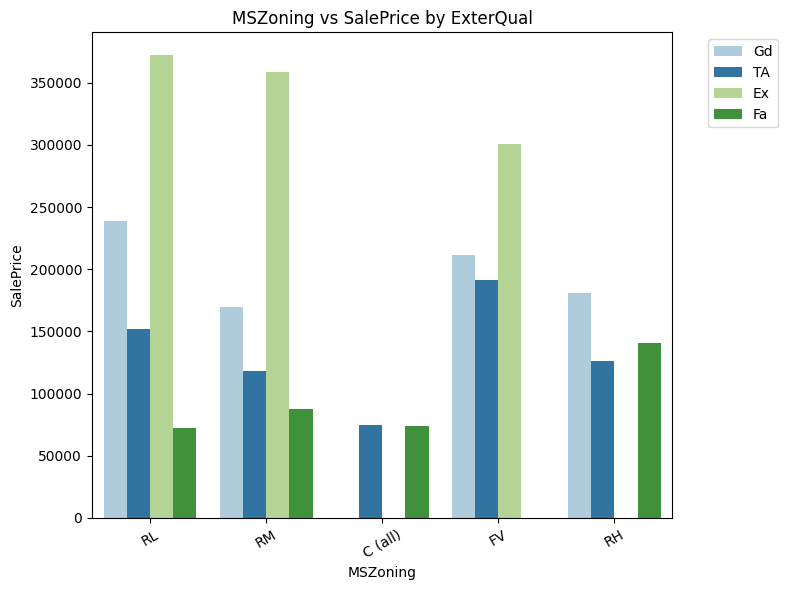

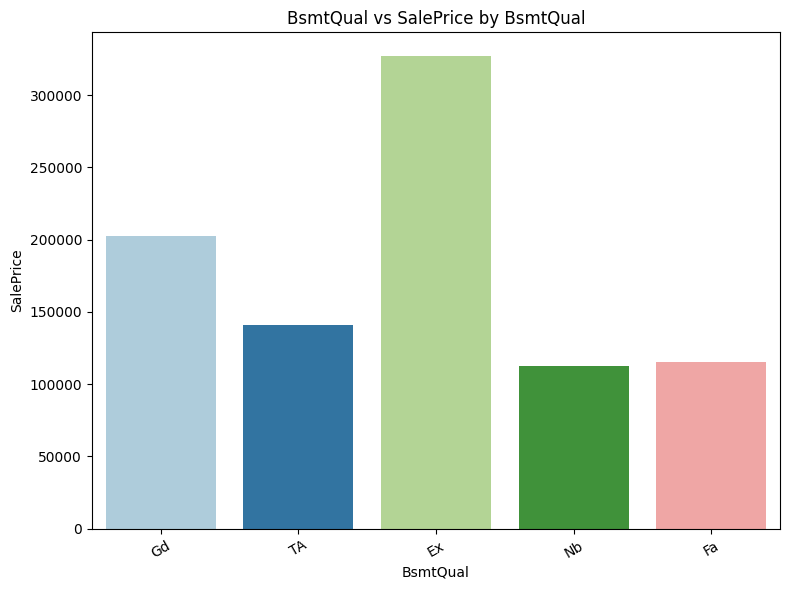

In [209]:
# sale prices group by MSZoning and binned by External Quality of property
_plt('bar', df, 'MSZoning', 'SalePrice', 'ExterQual')
_plt('bar', df, 'BsmtQual', 'SalePrice', 'BsmtQual')

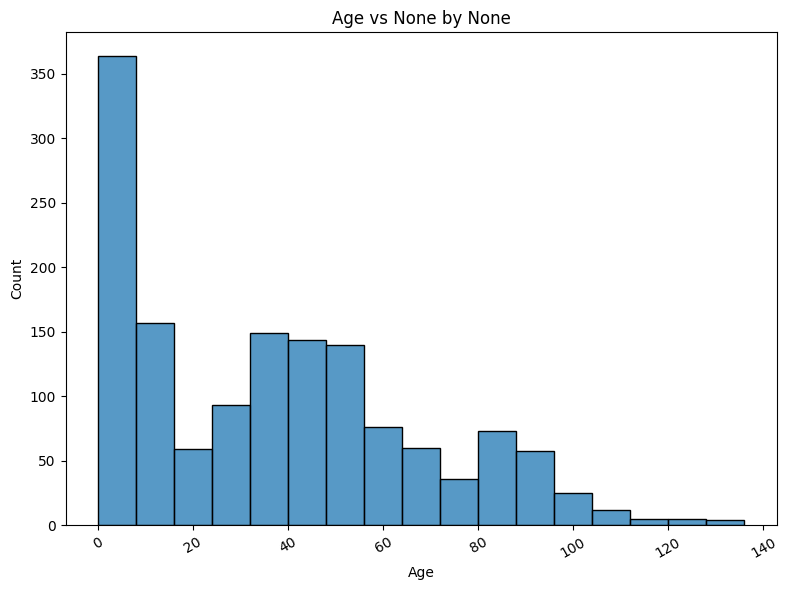

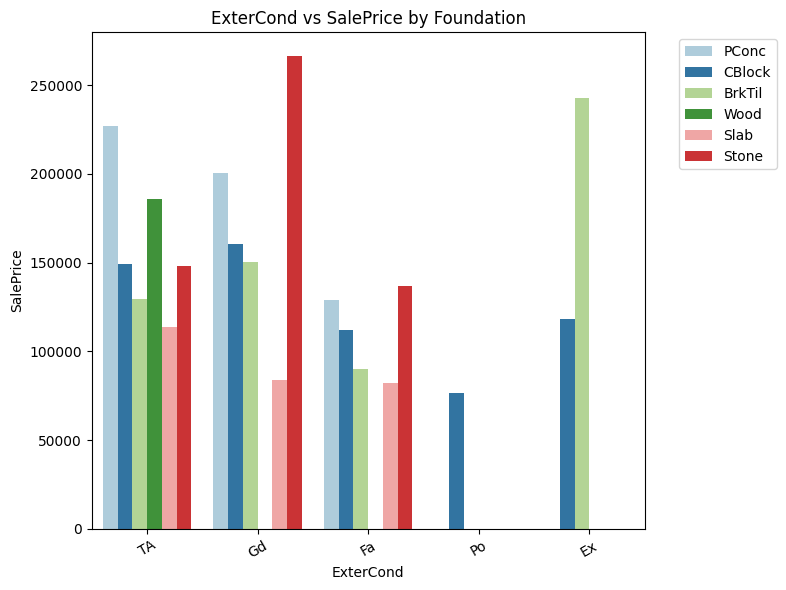

In [210]:
_plt('hist', df, 'Age')
_plt('bar', df, 'ExterCond', 'SalePrice', 'Foundation')

These plots show some interesting remarks about the houses and their prices.

There are a bunch of plots we can do but for now we'll keep it to this.